# ODE Modeling of Neuroblast Lineage Growth

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font size settings for figures
mpl.rcParams.update({
    "font.size": 14,              # base font size
    "axes.titlesize": 16,         # title font
    "axes.labelsize": 14,         # x/y label font
    "xtick.labelsize": 12,        # x-tick labels
    "ytick.labelsize": 12,        # y-tick labels
    "legend.fontsize": 12,        # legend text
    "lines.linewidth": 2,         # line thickness
    "axes.linewidth": 1.2,        # axis border thickness
})

# Function to make annotating data on figures easier
def annotate_final_values(ax, x, y_values, labels, min_sep_frac=0.1):
    """
    Adds annotations at the final time point of each y-series with spacing done in axis-fraction units.
    
    Parameters:
        ax: matplotlib Axes object
        x: time points (1D array)
        y_values: list of y-arrays
        labels: list of label strings
        min_sep_frac: minimum spacing between annotations in axis fraction (0.03 = 3% of y-axis height)
    """
    final_x = x[-1]
    final_ys = [y[-1] for y in y_values]
    y_min, y_max = ax.get_ylim()

    # Convert y-values to axis-fraction space
    y_fracs = [(y - y_min) / (y_max - y_min) for y in final_ys]

    # Sort and apply minimum spacing in axis-fraction space
    sorted_indices = np.argsort(y_fracs)
    new_frac_positions = {}
    last_frac = None
    for idx in sorted_indices:
        frac = y_fracs[idx]
        if last_frac is None:
            new_frac_positions[idx] = frac
        else:
            new_frac_positions[idx] = max(frac, last_frac + min_sep_frac)
        last_frac = new_frac_positions[idx]

    # Clamp to [0,1] and convert back to data coordinates
    for idx in range(len(y_values)):
        orig_y = final_ys[idx]
        frac_y = min(new_frac_positions[idx], 0.98)  # avoid going out of bounds
        adjusted_y = y_min + frac_y * (y_max - y_min)

        ax.annotate(f"{labels[idx]}\n{orig_y:.0f}",
                    xy=(final_x, orig_y),
                    xytext=(final_x + 1, adjusted_y),
                    textcoords='data',
                    fontsize=8,
                    va='center',
                    ha='left',
                    arrowprops=dict(arrowstyle='->', lw=0.5),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5))

## Modeling Cell Counts

This is a simple ODE model of that tracks the counts of each cell type in the developing neuroblast lineage. This model does not track cell volume and assumes homogeneous behavior within each cell type.

### Model Species
- **$N_{\text{NB}}$** - Number of neuroblasts, neuroblasts are stem-like cells that can divide asymmetrically yielding one neuroblast and one GMC or symmetrically yielding two neuroblasts
- **$N_{\text{GMC}}$** - Number of GMCs, Ganglion Mother Cells are neuron precursors that divide symmetrically into two neurons
- **$N_{\text{ImNeuron}}$** - Number of immature neurons. Immature neurons are terminally differentiated brain cells that do not grow nor divide. they mature into MatNeurons
- **$N_{\text{MatNeuron}}$** - Number of mature neurons. Mature neurons are terminally differentiated brain cells that do not grow, divide, nor change state.

### Model Parameters
- **$k_{\text{NB}}$** - the rate of neuroblast divisions, in units of divisions/hour
- **$k_{\text{GMC}}$** - the rate of GMC divisions, in units of divisions/hour
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour).
- **$\text{sym\_frac}$** - the fraction of neuroblast divisions that are symmetrical. Unitless.
  - Set to 0 for WT simulations and .15 for mudmut simulations

### Model Structure
The number of neuroblasts increases by 1 with each symmetric neuroblast division
$$\frac{dN_{\text{NB}}}{dt} = \text{sym\_frac} * k_{\text{NB}} * N_{\text{NB}}$$

The number of GMCs increases by 1 with each asymmetric neuroblast division and decreases by 1 with each GMC division.
$$\frac{dN_{\text{GMC}}}{dt} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} N_{\text{NB}} - k_{\text{GMC}} N_{\text{GMC}}$$

Immature neurons increase by 2 per GMC division and decrease as they mature:
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

Mature neurons increase as immature neurons mature:
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

### Model Limitations
- This model assumes homogeneous populations of neuroblasts, GMCs, and neurons, meaning that all cells within each type behave identically. It does not account for variability in growth rates, cell cycle timing, cell volume, or stochasticity in fate decisions
- This model treats the rates of division as constant over time and independent of population size or environmental feedback
- This model does not track cell volumes

In [2]:
def neuroblast_model(t, y, params):
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB, k_GMC, k_Neuron, sym_frac = params  # Division and maturation rates

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # ODEs
    dN_NB = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dN_MatNeuron = k_Neuron * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

### WT Simulation

**Parameter Justifications**
- Neuroblast division date - 1 division per 1.5 hours, from literature
- GMC division rate - 1 division per 9 hours, from literature
- Neuron maturation rate - 1 maturation per 48 hours, calibrated to allow WT lineages to have an average of 42 visable cells by the end of 48 hours

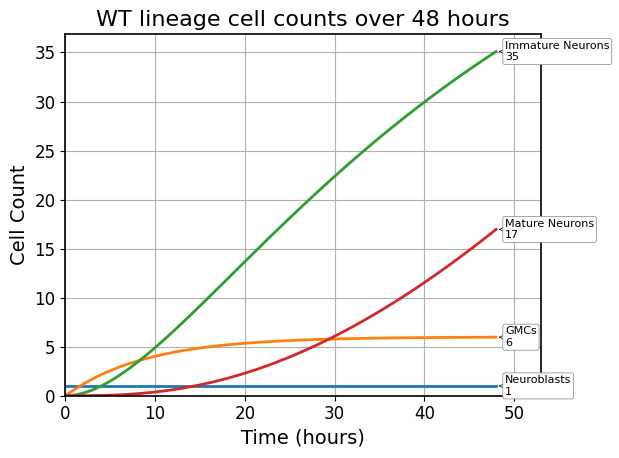

In [3]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,   # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.0      # 0% symmetric NB divisions for WT
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### mudmut Simulation

**Parameter Justifications**
I left all the parameters the same as the WT simulation except changed the percent symmetric divisions to .15.

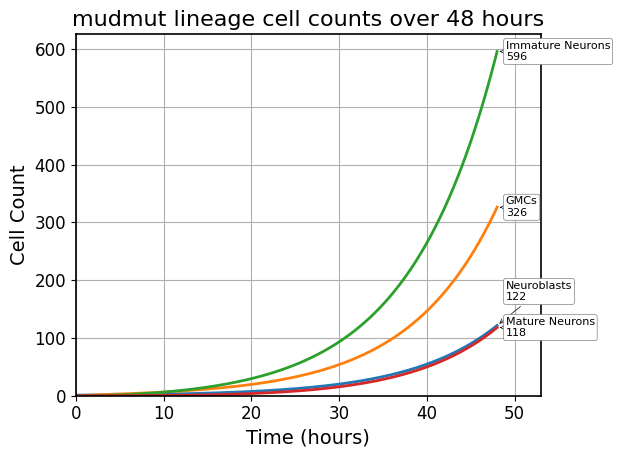

In [4]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,   # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.15      # 15% symmetric NB divisions for mudmut
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

### Conclusion from simple cell count model:
- ODE modling of cell growth and division behavior yields mud colonies with many more cells than wt colonies, which is the opposite of what is observed experimentally

---

# Modeling Volume-Dependent Division

This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, modeling a scenerio in which a cell will only divide if it has grown to a sufficient volume.

### Model Species
- **$N_{\text{NB}}$, $V_{\text{NB}}$** — Number and total volume of neuroblasts. Neuroblasts are stem-like cells that grow, and divide either symmetrically (producing two neuroblasts) or asymmetrically (producing one neuroblast and one GMC).
- **$N_{\text{GMC}}$, $V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs), which grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}}$, $V_{\text{ImNeuron}}$** — Number and total volume of immature neurons. These do not grow or divide, but they mature into mature neurons.
- **$N_{\text{MatNeuron}}$, $V_{\text{MatNeuron}}$** — Number and total volume of mature neurons, which do not grow, divide, or change state.

### Model Parameters
- **$g_{\text{NB}}$, $g_{\text{GMC}}$** — Growth rates (volume/hour) of neuroblasts and GMCs
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour)
- **$V_{\text{thresh\_NB}}$, $V_{\text{thresh\_GMC}}$** — Volume thresholds that control when neuroblasts and GMCs divide
- **$k_{\text{max\_NB}}$, $k_{\text{max\_GMC}}$** — Maximum possible division rates (divisions/hour) for neuroblasts and GMCs
- **$n$** — Hill coefficient controlling sharpness of the threshold response for division
- **$\text{sym\_frac}$** — Fraction of neuroblast divisions that are symmetric (unitless). Set to 0 for WT simulations and 0.15 for *mud* mutant simulations.

### Model Structure

GMC and Neuroblast division rates are volume-dependent via Hill-like sigmoid functions:
$$
k_{\text{NB}} = k_{\text{max\_NB}} \cdot \frac{(V_{\text{avg,NB}})^n}{(V_{\text{thresh\_NB}})^n + (V_{\text{avg,NB}})^n}
$$
$$
k_{\text{GMC}} = k_{\text{max\_GMC}} \cdot \frac{(V_{\text{avg,GMC}})^n}{(V_{\text{thresh\_GMC}})^n + (V_{\text{avg,GMC}})^n}
$$

Total volumes are updated based on growth and loss during division. For example:
- Neuroblast volume increases due to growth and redistributes during division
  - The NB compartment retains .8 * the average NB volume * the number of asymmetric divisions
- GMC volume increases due to growth, and contributes to neuron volume during division
  - the GMC compartment gets .2 * the average NB volume * the number of asymmetric divisions
- Immature neuron volume decreases as neurons mature into mature neurons

### Model Limitations
- Assumes average volume represents the division-readiness of the cell population
- Does not model individual cell variability or stochasticity in fate decisions
- Growth and division rates are continuous and deterministic, rather than step-like or event-driven

In [5]:
def neuroblast_model_volume_threshold_division(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    g_NB, g_GMC, k_Neuron, sym_frac, V_thresh_NB, V_thresh_GMC, k_max_NB, k_max_GMC, n = params

    # Avoid divide-by-zero
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Volume-dependent division rates
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons (produced by GMC division, mature at rate k_Neuron)
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons (accumulate from maturing immature neurons)
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT Simulation

**Parameter Justifications**
- Initial Neuroblast Volume (`nb_vol = 285` µm³)
  - Based on volumetric measurements from segmented microscopy data of wild-type neuroblasts. Average WT NB volume from `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx`.
- Neuroblast Growth Rate (`g_NB = (nb_vol × 0.2) / 1.5`)
  - Imposed to ensure neuroblasts grow by 20% over 1.5 hours.
- GMC Growth Rate (`g_GMC = (nb_vol × 0.6) / 9`)
  - Reflects GMCs starting at ~0.6× NB volume and growing to 1.2× NB volume over 9 hours, consistent with their expected doubling behavior before division.
- Neuroblast Division Threshold Volume (`V_thresh_NB = nb_vol × 1.2`)
  - Neuroblasts divide once they grow to 1.2× their initial volume.
- GMC Division Threshold Volume (`V_thresh_GMC = (V_thresh_NB × 0.2) × 2`)
  - GMCs are initialized at 20% of the neuroblast’s division volume and divide once they double in size.
- Maximum NB Division Rate (`k_max_NB = 1 / 0.25 hr⁻¹`)
  - Allows a maximum of one NB division every 15 minutes. This is intentionally faster than the average rate (~1 division per 1.5 hours) to allow for volume-dependent modulation via the Hill function. I calibrated this value to achieve approximately the expected number of cells by 48 hours, but we may need to refine. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Maximum GMC Division Rate (`k_max_GMC = 1 / 1.5` hr⁻¹)
  - Allows a maximum of one GMC division every 1.5 hours. As above, this is faster than the literature average (8–9 hours) to allow for volume-dependent control. I kept the fraction of the average division rate consistent between the two growth rate maxima (both are 1/6 the average growth rate).
- Hill Coefficient (`n = 6`)
  - Controls the steepness of the sigmoidal volume-to-division-rate transition. A value of 6 produces a sharp switch-like response near the threshold volume.
- Symmetric Division Fraction (`sym_frac = 0.0`)
  - Set to 0% to reflect wild-type neuroblast behavior, which divides asymmetrically.
- Neuron Maturation Rate (`k_Neuron = 1 / 48` hr⁻¹)
  - Carried over from the simpler model above.

### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

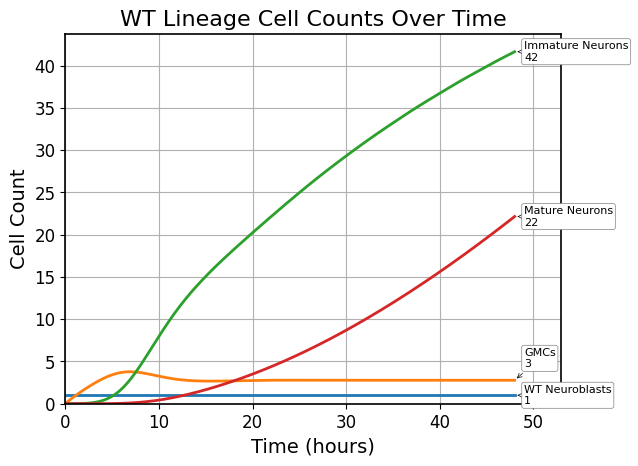

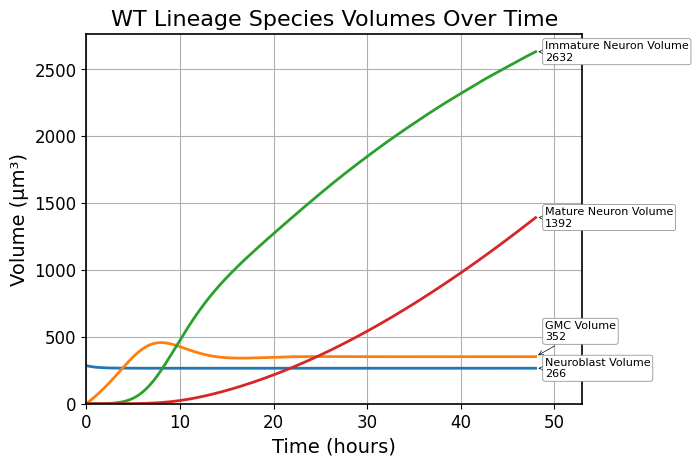

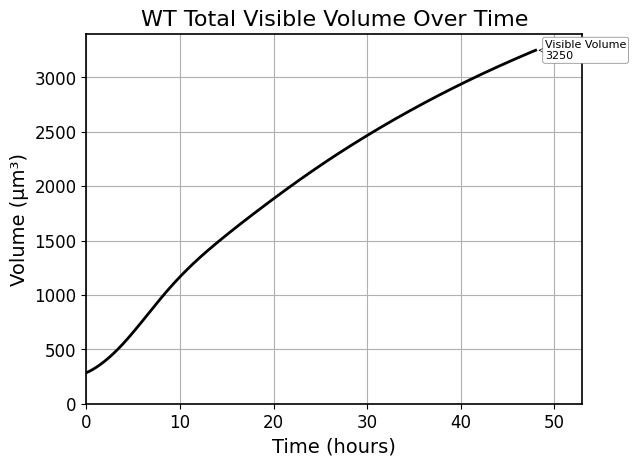

In [6]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.0               # 0% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

### mudmut Simulation

### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

**Parameter Justifications**

All Parameters are same as WT except:
- Symmetric Division Fraction (`sym_frac = 0.15`)
  - Set to 15% to reflect rate of mudmut neuroblast symmetric division

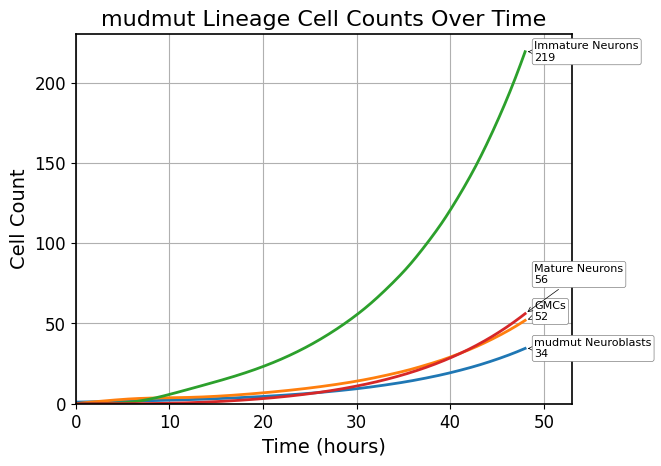

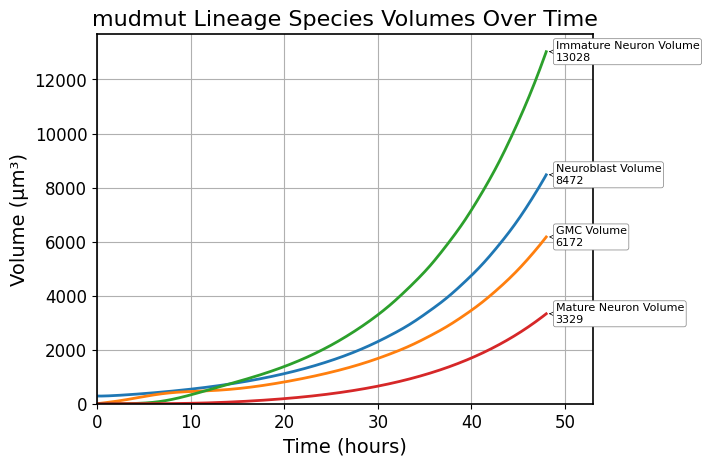

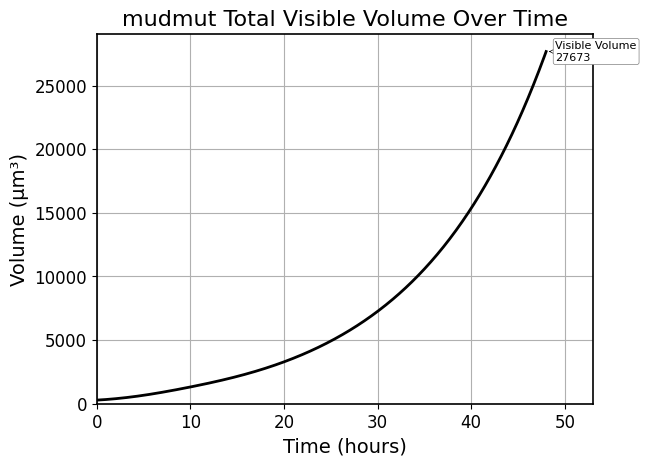

In [7]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_NB = (nb_vol * 0.2 / 1.5)       # NB grows 20% in 1.5 hours
g_GMC = ((nb_vol * 0.6) / 9)      # GMC grows from 0.6 * nb_volume to 1.2 * nb_vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * .2) * 2

k_max_NB = 1 / .25           # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5          # Max GMC division rate (1 per 1.5 hrs)
n = 6                        # Hill coefficient
sym_frac = 0.15              # 15% symmetric divisions
k_Neuron = 1 / 48            # Immature neurons mature in ~48 hrs

params = [
    g_NB,              # NB growth
    g_GMC,             # GMC growth
    k_Neuron,          # Neuron maturation rate
    sym_frac,          # Symmetric division fraction
    V_thresh_NB,       # NB threshold
    V_thresh_GMC,      # GMC threshold
    k_max_NB,          # NB max division rate
    k_max_GMC,         # GMC max division rate
    n                  # Hill coefficient
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

## Volume-dependent division conclusions
- WT lineage dynamics approximate what is seen in vivo
- mudmut lineages have far more cells and more volume than seen in vivo, suggesting that the model lacks necessary regulatory feedback

---

# Modeling Volume-Dependent Division with Cell-Count Feedback
**Cell count negatively regulates NB growth**

This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, and neuroblast **growth** (and therefore division indirectly) is **negatively regulated by the total number of cells** in the lineage. This allows the model to simulate self-limiting behavior, such as density-dependent feedback that may occur in vivo.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Number and total volume of neuroblasts. Neuroblasts grow and divide either symmetrically (producing two neuroblasts) or asymmetrically (producing one neuroblast and one GMC).
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs), which grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Number and total volume of immature neurons. These do not grow or divide, but they mature into mature neurons.
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Number and total volume of mature neurons, which do not grow, divide, or change state.


### Model Parameters
- **$g_{\text{NB}}$** — Maximum growth rate of neuroblasts (volume/hour), subject to feedback
- **$g_{\text{GMC}}$** — GMC growth rate (volume/hour)
- **$k_{\text{Neuron}}$** — Maturation rate of immature neurons to mature neurons (transitions/hour)
- **$V_{\text{thresh,NB}},\ V_{\text{thresh,GMC}}$** — Volume thresholds controlling when neuroblasts and GMCs divide
- **$k_{\text{max,NB}},\ k_{\text{max,GMC}}$** — Maximum division rates (divisions/hour)
- **$n$** — Hill coefficient controlling steepness of threshold response
- **$\text{sym\_frac}$** — Fraction of neuroblast divisions that are symmetric (unitless)
- **$K_{\text{feedback}}$** — Half-max constant for feedback based on total cell count


### Model Structure

**Feedback-modulated growth**:
$$
g_{\text{NB,eff}} = g_{\text{NB}} \cdot \frac{K_{\text{feedback}}}{K_{\text{feedback}} + N_{\text{total}}}
$$

**Volume-dependent division**:
$$
k_{\text{NB}} = k_{\text{max,NB}} \cdot \frac{V_{\text{avg,NB}}^n}{V_{\text{thresh,NB}}^n + V_{\text{avg,NB}}^n}
$$

$$
k_{\text{GMC}} = k_{\text{max,GMC}} \cdot \frac{V_{\text{avg,GMC}}^n}{V_{\text{thresh,GMC}}^n + V_{\text{avg,GMC}}^n}
$$

Where:
- $V_{\text{avg,NB}} = \frac{V_{\text{NB}}}{N_{\text{NB}}}$ (if $N_{\text{NB}} > 0$)
- $V_{\text{avg,GMC}} = \frac{V_{\text{GMC}}}{N_{\text{GMC}}}$ (if $N_{\text{GMC}} > 0$)
- $N_{\text{total}} = N_{\text{NB}} + N_{\text{GMC}} + N_{\text{ImNeuron}} + N_{\text{MatNeuron}}$

### Model Dynamics Summary
- Neuroblast growth is **slowed** as cell count increases.
- Division only occurs when a cell has grown sufficiently (volume threshold).
- The coupling of feedback to growth results in **indirect regulation of division**.
- GMCs contribute to immature neurons, which mature but do not divide.

### Model Limitations
- Assumes all cells of a type share the same average volume (no cell-to-cell variability)
- Feedback is global and based only on total cell count, not spatial constraints
- Continuous and deterministic; does not model discrete division events or stochasticity

In [8]:
def neuroblast_model_volume_threshold_cellcount_feedback(t, y, params):
    (
        N_NB, V_NB,
        N_GMC, V_GMC,
        N_ImNeuron, V_ImNeuron,
        N_MatNeuron, V_MatNeuron
    ) = y

    (
        g_NB_base, g_GMC,
        k_Neuron,
        sym_frac,
        V_thresh_NB, V_thresh_GMC,
        k_max_NB, k_max_GMC,
        n,
        K_feedback  # feedback strength (half-max total cell count)
    ) = params

    # Compute current average volumes
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Total cell count for feedback
    total_cells = N_NB + N_GMC + N_ImNeuron + N_MatNeuron

    # Apply negative feedback to NB growth only
    feedback_factor = K_feedback / (K_feedback + total_cells)
    g_NB = g_NB_base * feedback_factor

    # Volume-dependent division rate (no direct feedback)
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)

    # GMC division rate
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

### WT Simulation

### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Neuroblast Base Growth Rate** (`g_max_NB = (nb_vol * 0.2 / .25)`)
  - Calibrated so max rate at which neuroblasts grow 20% aligns with the maximum division rate. This is the *maximum* growth rate; it is dynamically reduced based on lineage size via cell-count feedback.

- **Symmetric Division Fraction** (`sym_frac = 0.0`)
  - WT Simulation

- **Feedback Strength** (`K_feedback = 10`)
  - Half-max feedback occurs when the total number of cells reaches 10. This was calibrated keeping all other parameters consistent to have the model approximate the expected lineage volume and visible cell count.

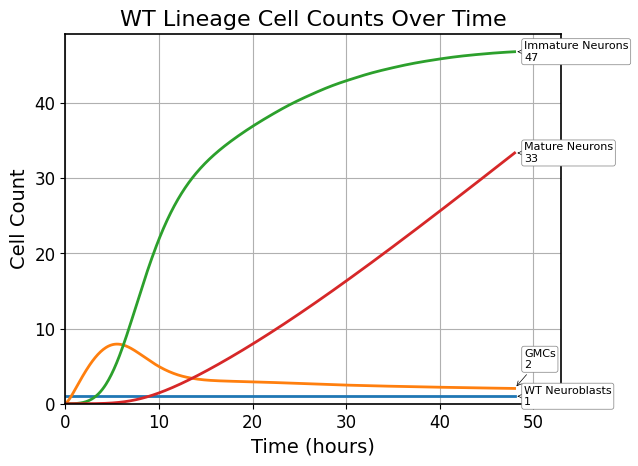

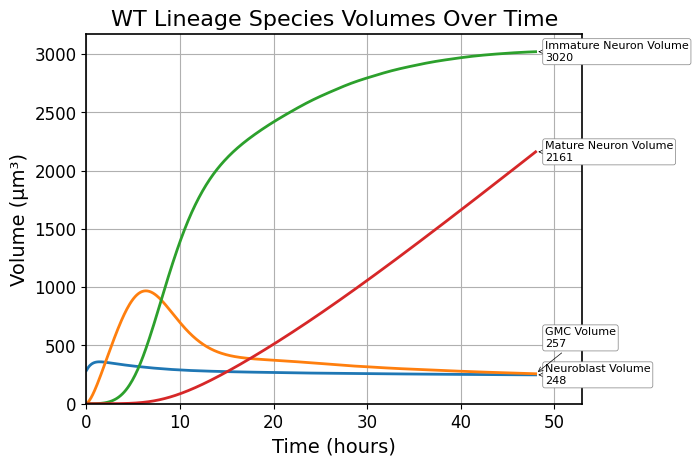

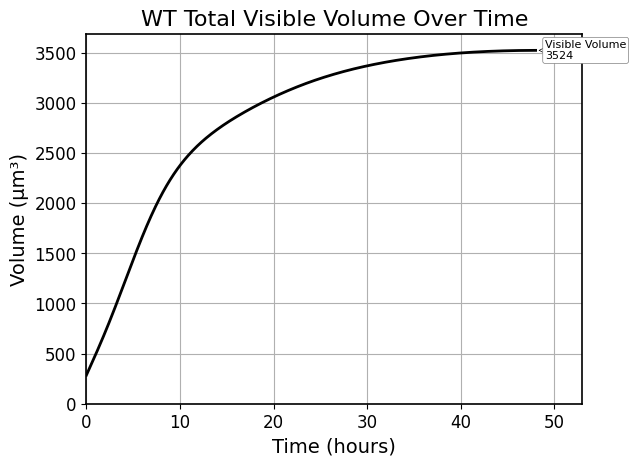

In [9]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / .25)      # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)         # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25    # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5    # Max GMC division rate (1 per 1.5 hrs)
n = 6                  # Hill coefficient
sym_frac = 0.0         # 0% symmetric divisions
k_Neuron = 1 / 48      # Immature neurons mature in ~48 hrs
K_feedback = 10        # Half-max cell count for feedback

params = [
    g_max_NB,     # Base NB growth rate (with feedback applied)
    g_GMC,         # GMC growth
    k_Neuron,      # Neuron maturation rate
    sym_frac,      # Symmetric division fraction
    V_thresh_NB,   # NB threshold
    V_thresh_GMC,  # GMC threshold
    k_max_NB,      # NB max division rate
    k_max_GMC,     # GMC max division rate
    n,             # Hill coefficient
    K_feedback     # Feedback strength (cell count half-max)
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_cellcount_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

### mudmut Simulation

### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

**Parameter Justifications**

All parameters are consistent with WT model above except `sym_frac = 0.15` to capture mudmutant symmetric division dynamics.

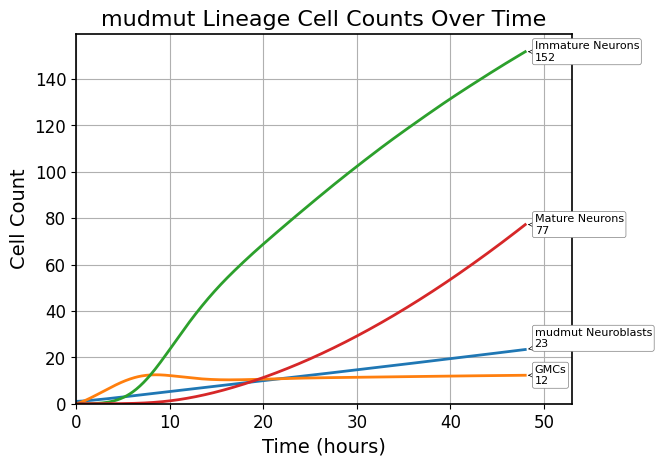

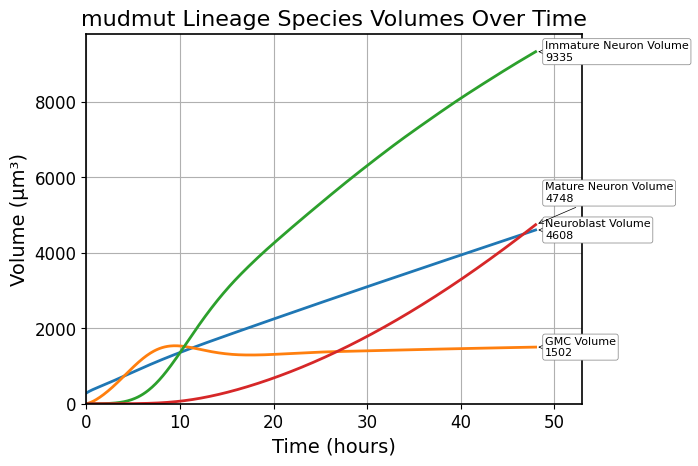

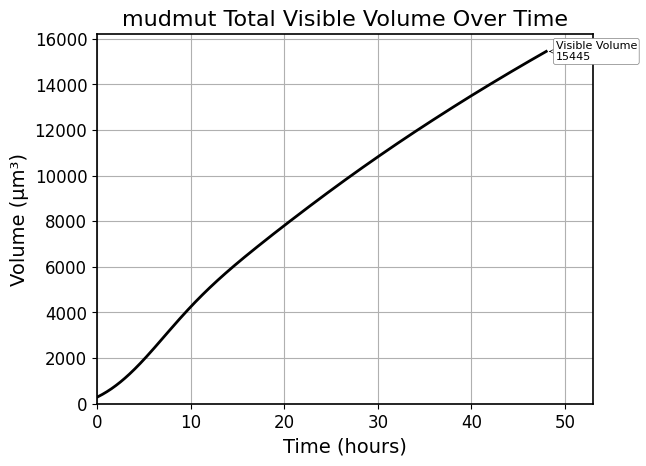

In [10]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / .25)      # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)         # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25    # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5    # Max GMC division rate (1 per 1.5 hrs)
n = 6                  # Hill coefficient
sym_frac = 0.15        # 15% symmetric divisions
k_Neuron = 1 / 48      # Immature neurons mature in ~48 hrs
K_feedback = 10        # Half-max cell count for feedback

params = [
    g_max_NB,     # Base NB growth rate (with feedback applied)
    g_GMC,         # GMC growth
    k_Neuron,      # Neuron maturation rate
    sym_frac,      # Symmetric division fraction
    V_thresh_NB,   # NB threshold
    V_thresh_GMC,  # GMC threshold
    k_max_NB,      # NB max division rate
    k_max_GMC,     # GMC max division rate
    n,             # Hill coefficient
    K_feedback     # Feedback strength (cell count half-max)
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_cellcount_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

## Cell-count feedback on NB growth conclusions
- Cell-count feedback on NB growth is insufficient to limit mudmut colony growth

---
# Modeling Volume-Dependent Division with GMC-Based Feedback  
**GMC count negatively regulates NB growth**

This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, and neuroblast **growth** (and therefore division indirectly) is **negatively regulated by the number of GMCs** in the lineage. This simulates a plausible feedback mechanism where neuroblasts slow down as intermediate progenitors (GMCs) accumulate, potentially reflecting niche or crowding effects.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Number and total volume of neuroblasts. Neuroblasts grow and divide either symmetrically (producing two neuroblasts) or asymmetrically (producing one neuroblast and one GMC).
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs), which grow and divide symmetrically into two immature neurons.
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Number and total volume of immature neurons. These do not grow or divide, but they mature into mature neurons.
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Number and total volume of mature neurons, which do not grow, divide, or change state.

### Model Parameters
- **$g_{\text{NB}}$** — Maximum growth rate of neuroblasts (volume/hour), subject to feedback from GMC count
- **$g_{\text{GMC}}$** — GMC growth rate (volume/hour)
- **$k_{\text{Neuron}}$** — Maturation rate of immature neurons to mature neurons (transitions/hour)
- **$V_{\text{thresh,NB}},\ V_{\text{thresh,GMC}}$** — Volume thresholds controlling when neuroblasts and GMCs divide
- **$k_{\text{max,NB}},\ k_{\text{max,GMC}}$** — Maximum division rates (divisions/hour)
- **$n$** — Hill coefficient controlling steepness of threshold response
- **$\text{sym\_frac}$** — Fraction of neuroblast divisions that are symmetric (unitless)
- **$K_{\text{feedback}}$** — Half-max constant for feedback based on GMC count

### Model Structure

**GMC-based feedback on NB growth**:  
$$
g_{\text{NB,eff}} = g_{\text{NB}} \cdot \frac{K_{\text{feedback}}}{K_{\text{feedback}} + N_{\text{GMC}}}
$$

**Volume-dependent division**:
$$
k_{\text{NB}} = k_{\text{max,NB}} \cdot \frac{V_{\text{avg,NB}}^n}{V_{\text{thresh,NB}}^n + V_{\text{avg,NB}}^n}
$$

$$
k_{\text{GMC}} = k_{\text{max,GMC}} \cdot \frac{V_{\text{avg,GMC}}^n}{V_{\text{thresh,GMC}}^n + V_{\text{avg,GMC}}^n}
$$

Where:
- $V_{\text{avg,NB}} = \frac{V_{\text{NB}}}{N_{\text{NB}}}$ (if $N_{\text{NB}} > 0$)  
- $V_{\text{avg,GMC}} = \frac{V_{\text{GMC}}}{N_{\text{GMC}}}$ (if $N_{\text{GMC}} > 0$)

### Model Dynamics Summary
- Neuroblast growth is **slowed** as GMC count increases.
- Division only occurs when a cell has grown sufficiently (volume threshold).
- Feedback only occurs on neuroblasts, with GMCs acting as the regulatory intermediate.
- GMCs divide into immature neurons, which mature but do not divide.

### Model Limitations
- Assumes all cells of a type share the same average volume (no cell-to-cell variability)
- Feedback is specific to GMC count and does not account for spatial organization
- Continuous and deterministic; does not model discrete division events or stochasticity


In [11]:
def neuroblast_model_volume_threshold_GMC_feedback(t, y, params):
    (
        N_NB, V_NB,
        N_GMC, V_GMC,
        N_ImNeuron, V_ImNeuron,
        N_MatNeuron, V_MatNeuron
    ) = y

    (
        g_NB_base, g_GMC,
        k_Neuron,
        sym_frac,
        V_thresh_NB, V_thresh_GMC,
        k_max_NB, k_max_GMC,
        n,
        K_feedback  # feedback strength (half-max GMC count)
    ) = params

    # Compute current average volumes
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Feedback is based ONLY on the number of GMCs
    feedback_factor = K_feedback / (K_feedback + N_GMC)
    g_NB = g_NB_base * feedback_factor

    # Volume-dependent division rate (no direct feedback)
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

## WT Simulation

## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Neuroblast Base Growth Rate** (`g_max_NB = (nb_vol * 0.2 / .25)`)
  - Calibrated so max rate at which neuroblasts grow 20% aligns with the maximum division rate. This is the *maximum* growth rate; it is dynamically reduced based on lineage size via cell-count feedback.

- **Symmetric Division Fraction** (`sym_frac = 0.0`)
  - WT Simulation

- **Feedback Strength** (`K_feedback = .5`)
  - Half-max feedback occurs when the number of GMCs is .5. This was calibrated keeping all other parameters consistent to have the model approximate the expected lineage volume and visible cell count.

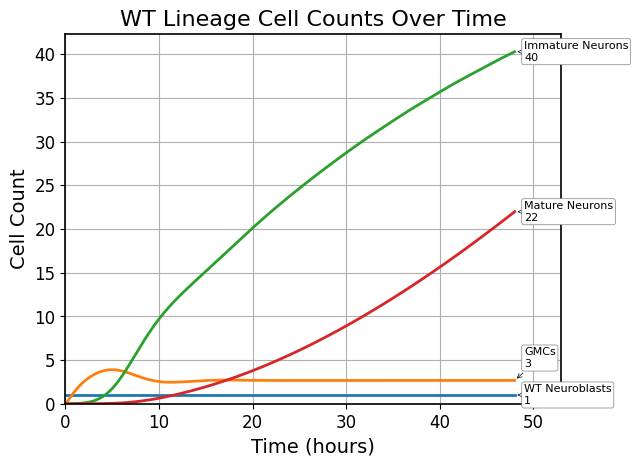

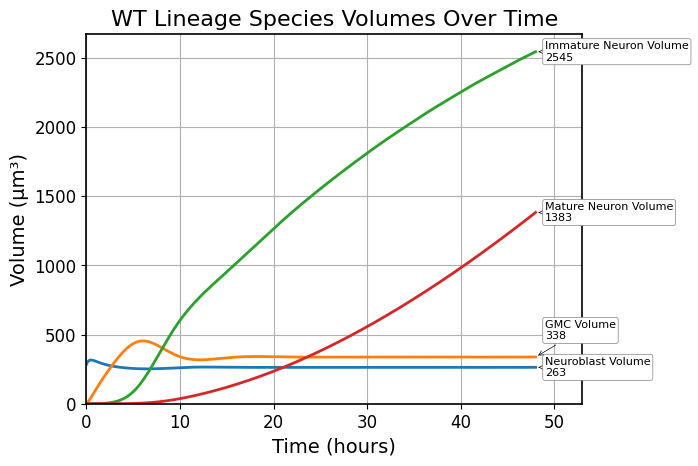

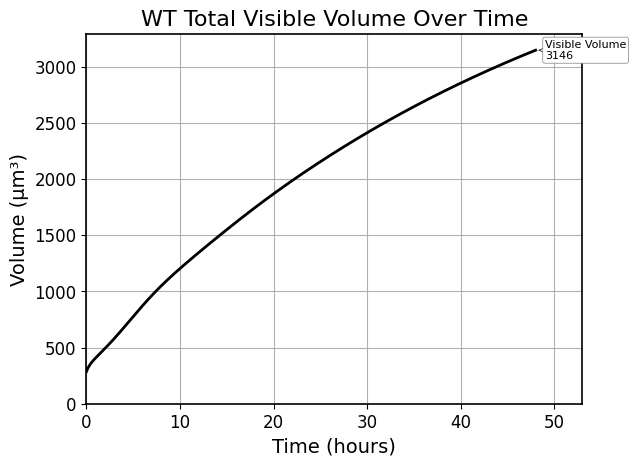

In [12]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / .25)      # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)         # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25    # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5    # Max GMC division rate (1 per 1.5 hrs)
n = 6                  # Hill coefficient
sym_frac = 0.0         # 0% symmetric divisions
k_Neuron = 1 / 48      # Immature neurons mature in ~48 hrs
K_feedback = 0.5       # Half-max cell count for feedback (tune as needed)

params = [
    g_max_NB,     # Base NB growth rate (with feedback applied)
    g_GMC,         # GMC growth
    k_Neuron,      # Neuron maturation rate
    sym_frac,      # Symmetric division fraction
    V_thresh_NB,   # NB threshold
    V_thresh_GMC,  # GMC threshold
    k_max_NB,      # NB max division rate
    k_max_GMC,     # GMC max division rate
    n,             # Hill coefficient
    K_feedback     # Feedback strength (cell count half-max)
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_GMC_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["WT Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.show()

## MUDMUT Simulation

### Target Dynamics
Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15

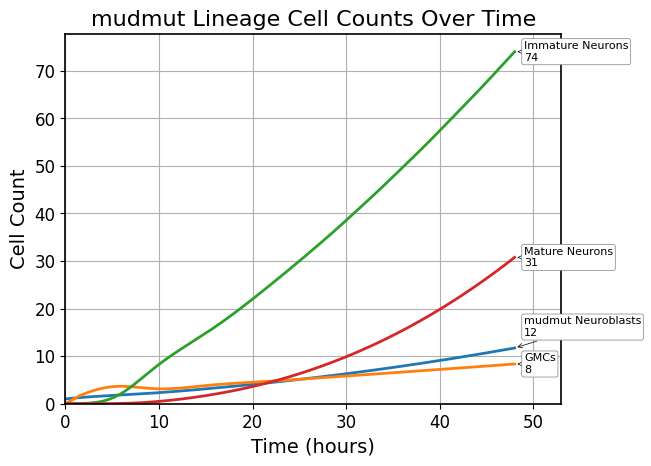

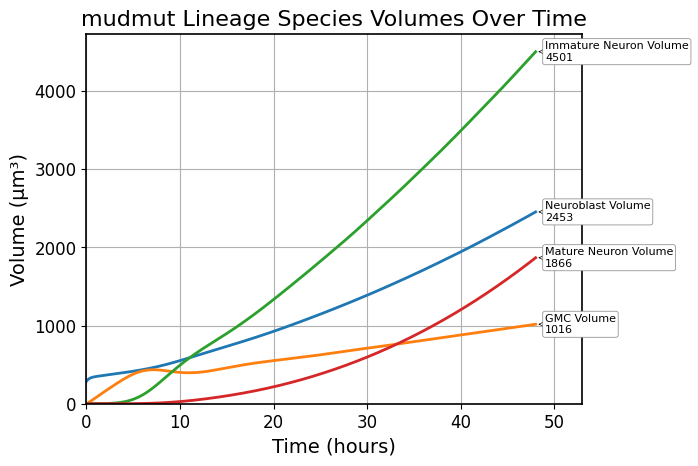

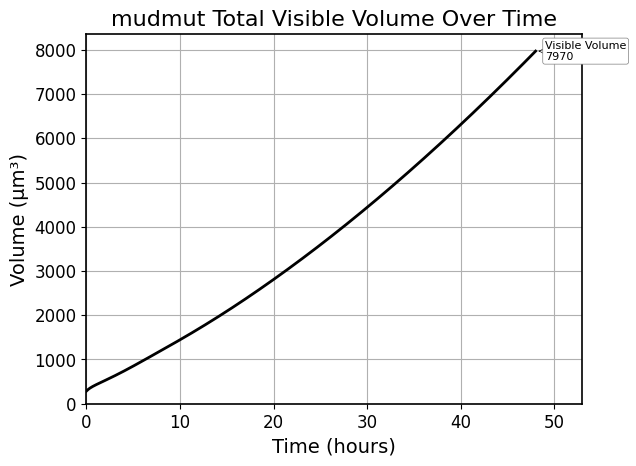

In [13]:
# Initial WT neuroblast volume (um^3, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / .25)      # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)         # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25    # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5    # Max GMC division rate (1 per 1.5 hrs)
n = 6                  # Hill coefficient
sym_frac = 0.15        # 15% symmetric divisions
k_Neuron = 1 / 48      # Immature neurons mature in ~48 hrs
K_feedback = 0.5       # Half-max cell count for feedback (tune as needed)

params = [
    g_max_NB,     # Base NB growth rate (with feedback applied)
    g_GMC,         # GMC growth
    k_Neuron,      # Neuron maturation rate
    sym_frac,      # Symmetric division fraction
    V_thresh_NB,   # NB threshold
    V_thresh_GMC,  # GMC threshold
    k_max_NB,      # NB max division rate
    k_max_GMC,     # GMC max division rate
    n,             # Hill coefficient
    K_feedback     # Feedback strength (cell count half-max)
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 2 days
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_volume_threshold_GMC_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["mudmut Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.show()

# Plot total volumes
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.show()

# Plot total visible lineage volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]  # NB + GMC + immature neuron volumes
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.show()

## GMC-based feedback on NB growth conclusions
- Also insufficient to limit mudmut colony growth

---

# Modeling Volume-Dependent Division with Total Volume Feedback 
**Total lineage volume negatively regulates NB growth**

This model tracks both the number and total volume of each cell type in the developing neuroblast lineage. Division rates are **volume-dependent**, and neuroblast **growth** (and therefore division indirectly) is **negatively regulated by the total volume of the lineage**. This reflects a global size-sensing feedback mechanism, such as might occur via morphogen dilution or biophysical constraints.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Number and total volume of neuroblasts.
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells (GMCs).
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Number and total volume of immature neurons.
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Number and total volume of mature neurons.

### Model Parameters
- **$g_{\text{NB}}$** — Maximum growth rate of neuroblasts (volume/hour), subject to feedback
- **$g_{\text{GMC}}$** — GMC growth rate (volume/hour)
- **$k_{\text{Neuron}}$** — Maturation rate of immature neurons (transitions/hour)
- **$V_{\text{thresh,NB}},\ V_{\text{thresh,GMC}}$** — Volume thresholds for division
- **$k_{\text{max,NB}},\ k_{\text{max,GMC}}$** — Maximum division rates
- **$n$** — Hill coefficient (steepness of division threshold)
- **$\text{sym\_frac}$** — Fraction of NB divisions that are symmetric
- **$V_{\text{feedback}}$** — Volume threshold at which NB growth is halved (half-max constant)

### Model Structure

**Volume-based feedback on NB growth**:
$$
g_{\text{NB,eff}} = g_{\text{NB}} \cdot \frac{V_{\text{feedback}}}{V_{\text{feedback}} + V_{\text{total}}}
$$

**Volume-dependent division**:
$$
k_{\text{NB}} = k_{\text{max,NB}} \cdot \frac{V_{\text{avg,NB}}^n}{V_{\text{thresh,NB}}^n + V_{\text{avg,NB}}^n}
$$

$$
k_{\text{GMC}} = k_{\text{max,GMC}} \cdot \frac{V_{\text{avg,GMC}}^n}{V_{\text{thresh,GMC}}^n + V_{\text{avg,GMC}}^n}
$$

Where:
- $V_{\text{avg,NB}} = \frac{V_{\text{NB}}}{N_{\text{NB}}}$
- $V_{\text{avg,GMC}} = \frac{V_{\text{GMC}}}{N_{\text{GMC}}}$
- $V_{\text{total}} = V_{\text{NB}} + V_{\text{GMC}} + V_{\text{ImNeuron}} + V_{\text{MatNeuron}}$

### Model Dynamics Summary
- Neuroblast growth is **slowed** as total lineage volume increases.
- Feedback only affects neuroblast growth, which indirectly slows division.

### Model Limitations
- Assumes all cells of a type share the same average volume
- No spatial constraints or cell-to-cell variability
- Deterministic and continuous; no stochasticity or discrete events

In [14]:
def neuroblast_model_volume_threshold_total_volume_feedback(t, y, params):
    (
        N_NB, V_NB,
        N_GMC, V_GMC,
        N_ImNeuron, V_ImNeuron,
        N_MatNeuron, V_MatNeuron
    ) = y

    (
        g_NB_base, g_GMC,
        k_Neuron,
        sym_frac,
        V_thresh_NB, V_thresh_GMC,
        k_max_NB, k_max_GMC,
        n,
        V_feedback  # feedback threshold (volume at half-max)
    ) = params

    # Compute current average volumes
    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    # Total lineage volume for feedback
    total_volume = V_NB + V_GMC + V_ImNeuron + V_MatNeuron

    # Apply negative feedback to NB growth based on total volume
    feedback_factor = V_feedback / (V_feedback + total_volume)
    g_NB = g_NB_base * feedback_factor

    # Volume-dependent division rate
    k_NB = k_max_NB * (Vavg_NB ** n) / (V_thresh_NB ** n + Vavg_NB ** n)
    k_GMC = k_max_GMC * (Vavg_GMC ** n) / (V_thresh_GMC ** n + Vavg_GMC ** n)

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neurons
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neurons
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

## WT Simulation
## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Symmetric Division Fraction** (`sym_frac = 0.0`)
  - WT Simulation

- **Feedback Strength** (`V_feedback = 3000`)
  - Half-max feedback occurs when the total lineage volume is 3000 um^3. This was calibrated keeping all other parameters consistent to have the model approximate the expected lineage volume and visible cell count.

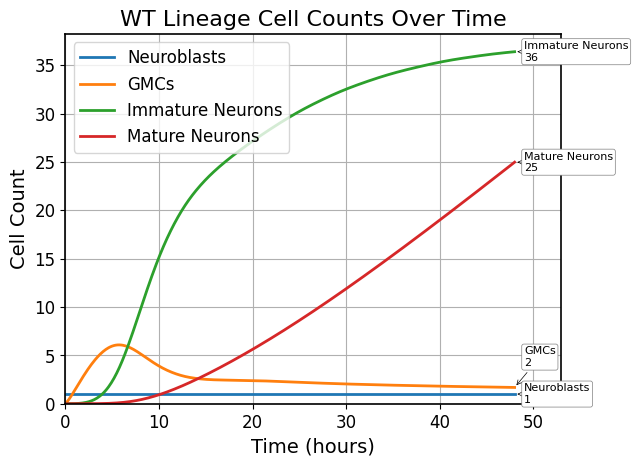

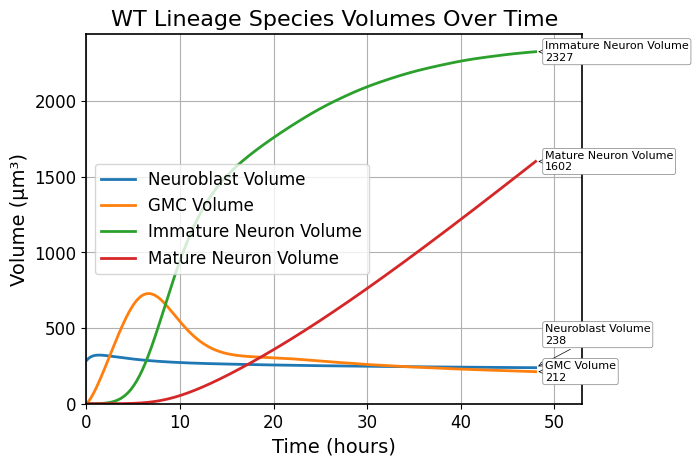

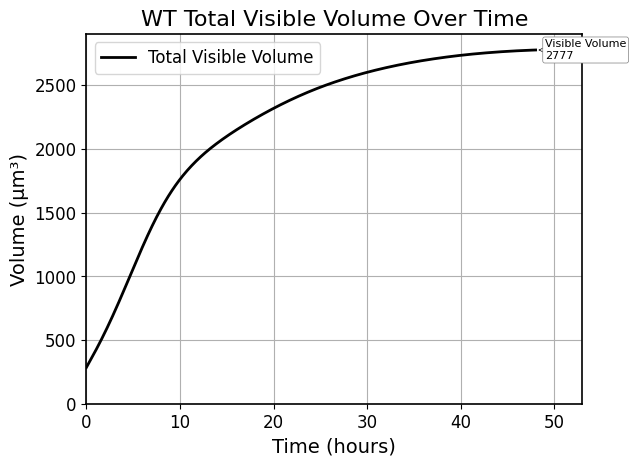

In [15]:
# Initial WT neuroblast volume (μm³, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / 0.25)        # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)            # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25     # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5     # Max GMC division rate (1 per 1.5 hrs)
n = 6                   # Hill coefficient
sym_frac = 0.0          # 0% symmetric divisions
k_Neuron = 1 / 48       # Immature neurons mature in ~48 hrs
V_feedback = 400       # Volume threshold at which NB growth is halved

params = [
    g_max_NB,     # NB max growth rate
    g_GMC,        # GMC growth rate
    k_Neuron,     # Neuron maturation rate
    sym_frac,     # Symmetric division fraction
    V_thresh_NB,  # NB division threshold
    V_thresh_GMC, # GMC division threshold
    k_max_NB,     # NB max division rate
    k_max_GMC,    # GMC max division rate
    n,            # Hill coefficient
    V_feedback    # Feedback threshold based on total volume
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span and evaluation points
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Solve ODEs
sol = solve_ivp(
    neuroblast_model_volume_threshold_total_volume_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot: Cell Counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts Over Time")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Volume per Species
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title("WT Lineage Species Volumes Over Time")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

## mudmut Simulation
### Target Dynamics

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15

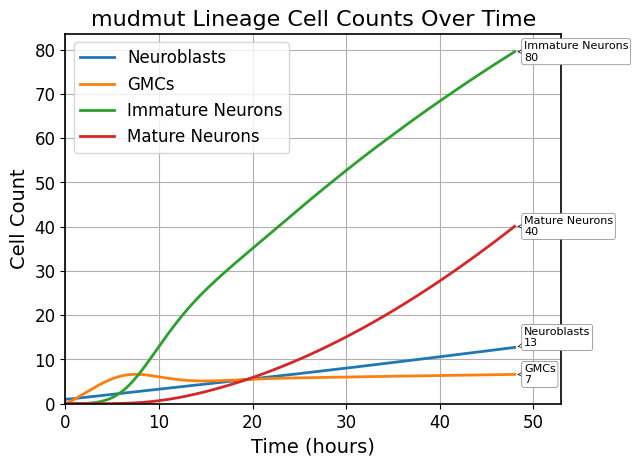

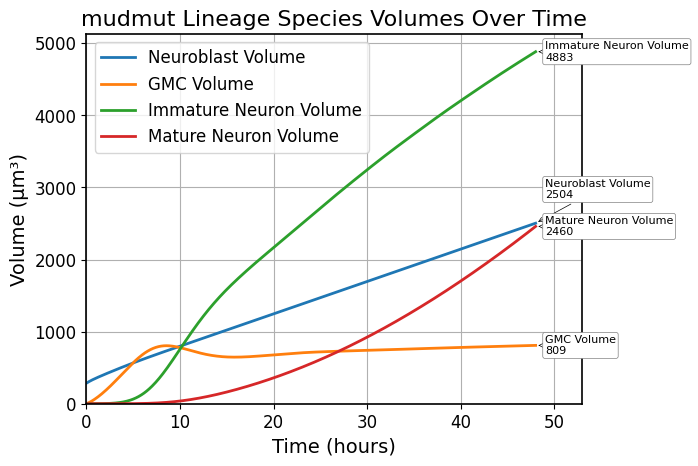

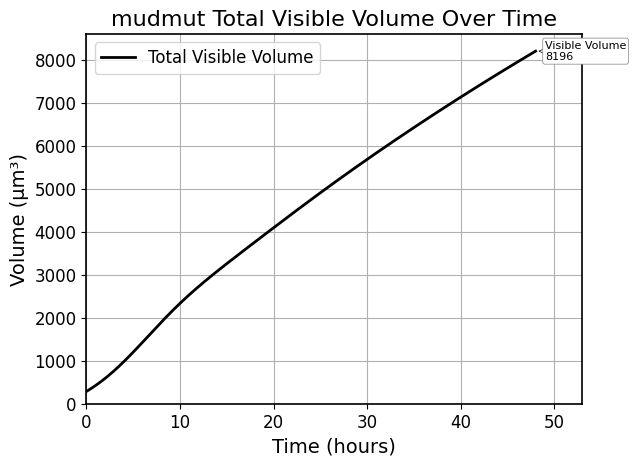

In [16]:
# Initial WT neuroblast volume (μm³, from volumetric data)
nb_vol = 285

# Parameters
g_max_NB = (nb_vol * 0.2 / 0.25)        # NB grows 20% in 15 mins
g_GMC = ((nb_vol * 0.6) / 9)            # GMC grows from 0.6× to 1.2× NB vol in 9 hours

V_thresh_NB = nb_vol * 1.2
V_thresh_GMC = (V_thresh_NB * 0.2) * 2

k_max_NB = 1 / 0.25     # Max NB division rate (1 per 15 mins)
k_max_GMC = 1 / 1.5     # Max GMC division rate (1 per 1.5 hrs)
n = 6                   # Hill coefficient
sym_frac = 0.15         # 15% symmetric divisions
k_Neuron = 1 / 48       # Immature neurons mature in ~48 hrs
V_feedback = 400       # Volume threshold at which NB growth is halved

params = [
    g_max_NB,     # NB max growth rate
    g_GMC,        # GMC growth rate
    k_Neuron,     # Neuron maturation rate
    sym_frac,     # Symmetric division fraction
    V_thresh_NB,  # NB division threshold
    V_thresh_GMC, # GMC division threshold
    k_max_NB,     # NB max division rate
    k_max_GMC,    # GMC max division rate
    n,            # Hill coefficient
    V_feedback    # Feedback threshold based on total volume
]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span and evaluation points
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Solve ODEs
sol = solve_ivp(
    neuroblast_model_volume_threshold_total_volume_feedback,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot: Cell Counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts Over Time")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Volume per Species
fig, ax = plt.subplots()
labels_vol = ["Neuroblast Volume", "GMC Volume", "Immature Neuron Volume", "Mature Neuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]

for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title("mudmut Lineage Species Volumes Over Time")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

## GMC-based feedback on NB growth conclusions
- Also insufficient to limit mudmut colony growth

---

# Modeling Uncoupled Growth and Division

**NB and GMC growth/division rates are fully independent**

This model tracks the number and total volume of neuroblasts, GMCs, and neurons over time. In contrast to previous models, the **growth and division of neuroblasts and GMCs are uncoupled**, meaning their growth rates and division rates are independently tunable. Neuron maturation is retained.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Neuroblast count and volume. Neuroblasts grow at rate $g_{\text{NB}}$ and divide at rate $k_{\text{NB}}$.
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — GMC count and volume. GMCs grow at rate $g_{\text{GMC}}$ and divide at rate $k_{\text{GMC}}$ into two immature neurons.
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Immature neurons, which mature at rate $k_{\text{Neuron}}$.
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Mature neurons, which do not divide or change state.

### Model Parameters
- **$g_{\text{NB}},\ g_{\text{GMC}}$** — Growth rates (volume/hour)
- **$k_{\text{NB}},\ k_{\text{GMC}}$** — Division rates (divisions/hour)
- **$k_{\text{Neuron}}$** — Maturation rate (transitions/hour)
- **$\text{sym\_frac}$** — Fraction of NB divisions that are symmetric

### Model Dynamics Summary
- Growth and division are fully decoupled for both NBs and GMCs.
- Symmetric and asymmetric NB divisions produce different cell types and volumes.
- GMCs produce immature neurons, which later mature into mature neurons.

In [17]:
def neuroblast_model_uncoupled_growth_division(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y

    (
        k_NB, g_NB,
        k_GMC, g_GMC,
        k_Neuron,
        sym_frac
    ) = params

    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Neuroblast dynamics
    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    # GMC dynamics
    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    # Immature neuron dynamics
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    # Mature neuron dynamics
    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

## WT Simulation
## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Neuroblast Division Rate** (`k_NB = 1 / 1.5`)
  - Neuroblasts divide every 90 minutes (from literature).

- **Neuroblast Growth Rate** (`nb_vol * 0.2 / 1.5`)
  - Neuroblasts grow by 20% of their starting volume over 1.5 hours (from literature).

- **GMC Division Rate** (`k_GMC = 1 / 9`)
  - GMCs divide every 9 hours (from literature).

- **GMC Growth Rate** (`nb_vol * 0.6 / 9`)
  - GMCs grow from 0.6× to 1.2× the NB volume in 9 hours (from literature).

- **Symmetric Division Fraction** ($\text{sym\_frac} = 0.0$)
  - All divisions are asymmetric (WT condition).

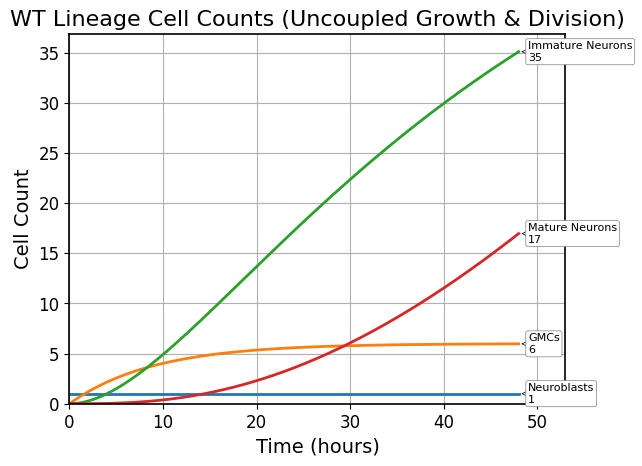

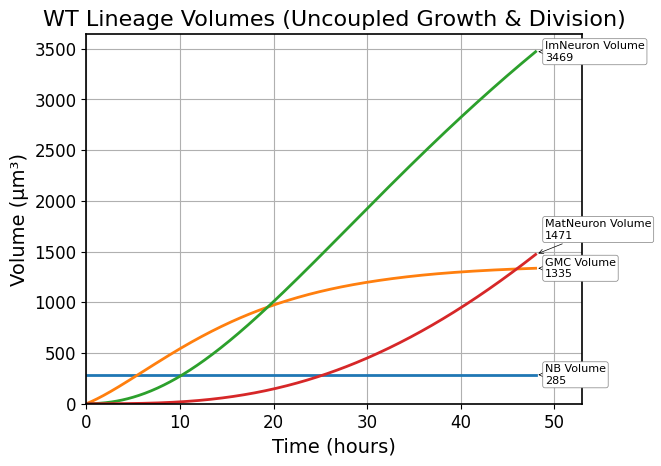

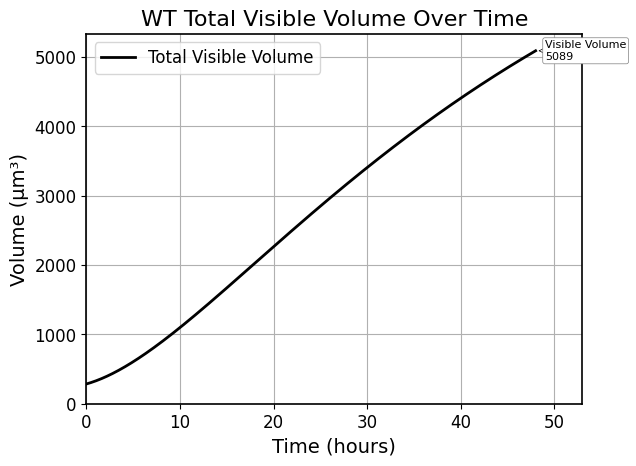

In [18]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_NB = 1 / 1.5              # NB divides every 90 min
g_NB = nb_vol * 0.2 / 1.5   # NB grows 20% in 1.5 hrs
k_GMC = 1 / 9               # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9    # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48           # Neurons mature in 48 hrs
sym_frac = 0.0              # 0% symmetric divisions

params = [k_NB, g_NB, k_GMC, g_GMC, k_Neuron, sym_frac]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_uncoupled_growth_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

## mudmut Simulation
### Target Dynamics

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15

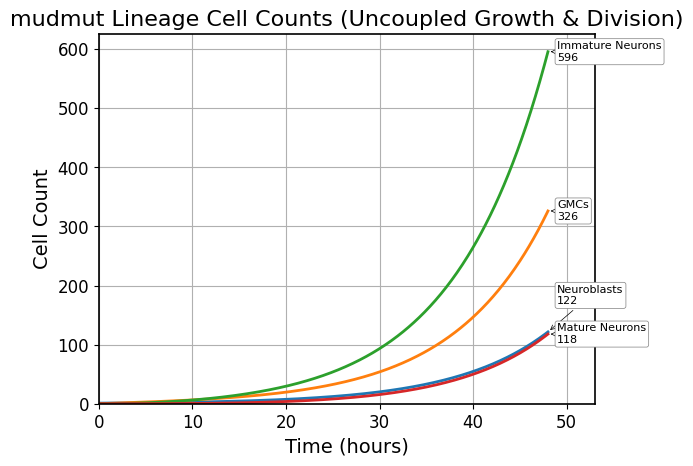

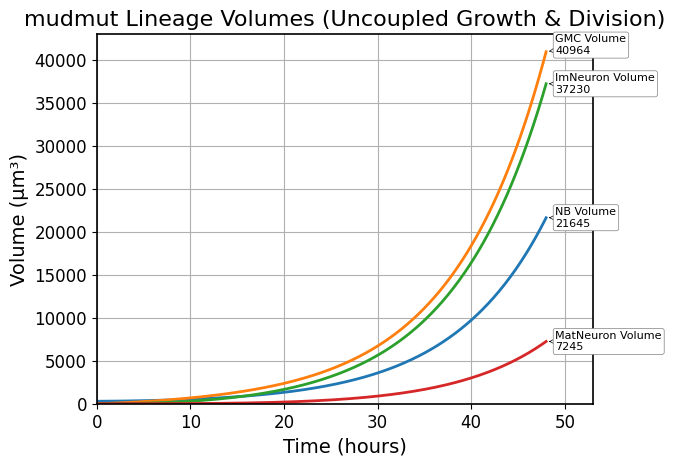

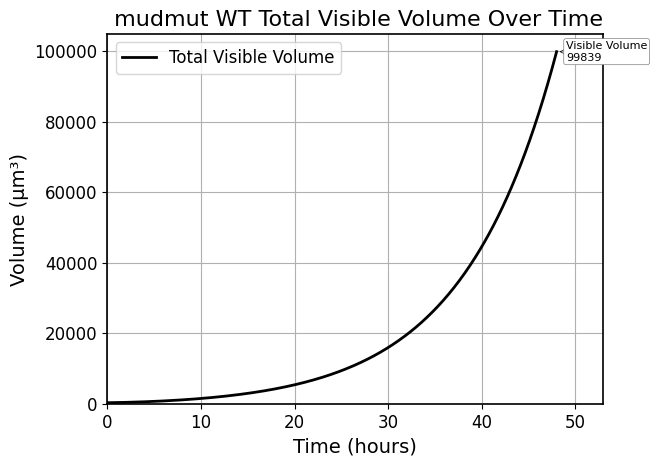

In [19]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_NB = 1 / 1.5              # NB divides every 90 min
g_NB = nb_vol * 0.2 / 1.5   # NB grows 20% in 1.5 hrs
k_GMC = 1 / 9               # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9    # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48           # Neurons mature in 48 hrs
sym_frac = 0.15             # 15% symmetric divisions

params = [k_NB, g_NB, k_GMC, g_GMC, k_Neuron, sym_frac]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_uncoupled_growth_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (μm³)")
ax.set_title(" mudmut WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

**Conclusions:** Similar to coupled simulation, without regulation mudmutant lineages proliferate unrealistically.

---

# Cell Count Feedback on NB Growth Only

This model includes uncoupled growth and division rates for neuroblasts and GMCs, and introduces **negative feedback on neuroblast growth** based on the total number of cells in the lineage. Division rates remain fixed. This simulates density-dependent limits on NB growth.

#### **Model Species**
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Number and total volume of neuroblasts.
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Number and total volume of Ganglion Mother Cells.
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Immature neurons (from GMCs), maturing over time.
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Mature neurons (do not grow or divide).

#### **Parameters**
- **$k_{\text{NB}}$** — Fixed NB division rate
- **$g_{\text{NB}}$** — Maximal NB growth rate (subject to feedback)
- **$k_{\text{GMC}}$** — Fixed GMC division rate
- **$g_{\text{GMC}}$** — GMC growth rate
- **$k_{\text{Neuron}}$** — Neuron maturation rate
- **$\text{sym\_frac}$** — Symmetric NB division fraction
- **$K_{\text{feedback}}$** — Half-max constant for feedback based on total cell count

#### **Model Structure**

**Feedback on NB growth only**:
$$
g_{\text{NB,eff}} = g_{\text{NB}} \cdot \frac{K_{\text{feedback}}}{K_{\text{feedback}} + N_{\text{total}}}
$$

- Growth of neuroblasts slows as total cell count increases.
- Division rates are fixed and uncoupled from growth.

#### **Key Features**
- Uncoupled growth and division
- Feedback only on NB growth
- Maturation of neurons retained

#### **Limitations**
- No spatial representation or stochasticity
- Assumes uniform average volume within each cell type

In [20]:
def neuroblast_model_cellcount_feedback_on_growth_only(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    k_NB, g_max_NB, k_GMC, g_GMC, k_Neuron, sym_frac, K_feedback = params

    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    total_cells = N_NB + N_GMC + N_ImNeuron + N_MatNeuron
    g_NB = g_max_NB * K_feedback / (K_feedback + total_cells)

    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [dN_NB, dV_NB, dN_GMC, dV_GMC, dN_ImNeuron, dV_ImNeuron, dN_MatNeuron, dV_MatNeuron]

## WT Simulation
## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **g_max_NB** (`g_NB = nb_vol * 0.2 / 1.5`) - Set to max growth rate used in earlier coupled model
- **$K_{feedback}$** (`K_feedback = .1`) - Set to be extremely minimal

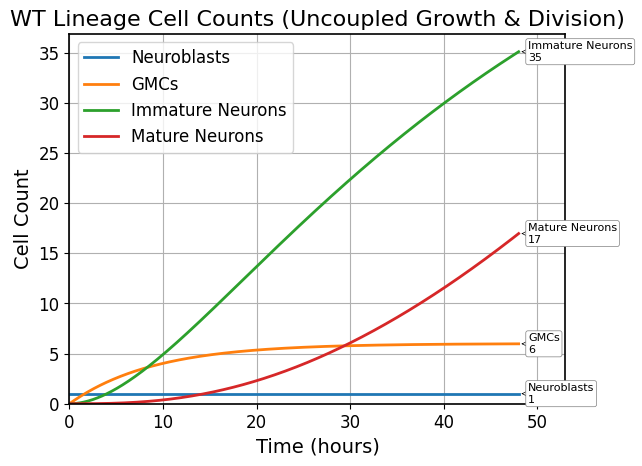

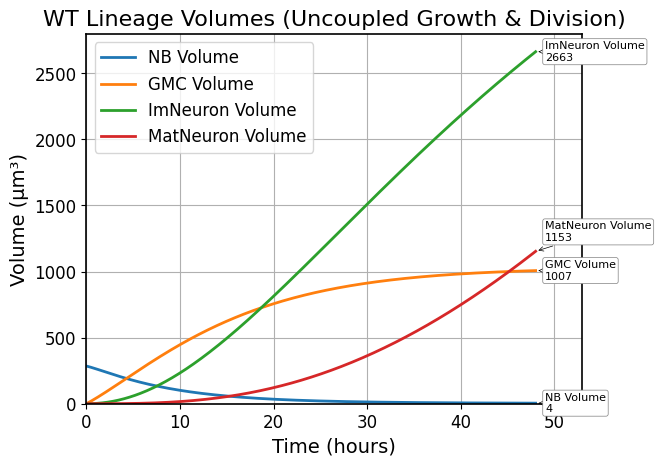

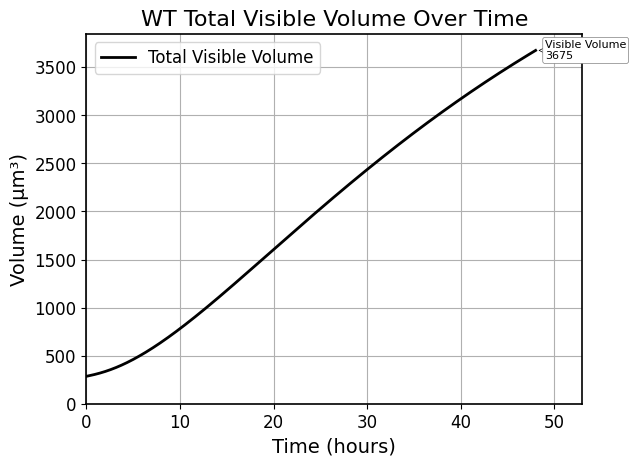

In [21]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_NB = 1 / 1.5                          # NB divides every 90 min
g_max_NB = (nb_vol * 0.2 / 0.25)        # NB grows 20% in 15 mins
k_GMC = 1 / 9                           # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9                # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48                       # Neurons mature in 48 hrs
sym_frac = 0.0                          # 0% symmetric divisions
K_feedback = .1                          # Half-max total cell count for NB growth feedback

params = [k_NB, g_max_NB, k_GMC, g_GMC, k_Neuron, sym_frac, K_feedback]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_cellcount_feedback_on_growth_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

### Skipping mudmut simulation here as the GMC growth rate dominates the system, feedback on NBs alone is not able to constrain lineage volume

---
# Applying GMC count feedback to just NB growth (not division)

### Skipping this as well due to finding of the model above. If the division rate is unconstrained then feedback on the NB growth rate alone is insufficient to constrain lineage growth, GMC growth rate will dominate.

---
# Lineage volume feedback on NB growth only

**Total lineage volume negatively regulates NB growth**  
In this model, neuroblast and GMC **growth** and **division** are uncoupled:
- NB **growth** is negatively regulated by **total lineage volume**
- Division rates for both NB and GMC are fixed and **not** volume-dependent
- GMC growth and neuron maturation proceed independently

This allows investigation of how total lineage size might regulate neuroblast expansion via growth inhibition, without directly altering cell cycle timing.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Neuroblasts
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Immature Neurons
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Mature Neurons

### Model Parameters
- **$k_{\text{NB}},\ g_{\text{NB,max}}$** — NB division rate and max growth rate
- **$k_{\text{GMC}},\ g_{\text{GMC}}$** — GMC division rate and growth rate
- **$k_{\text{Neuron}}$** — Maturation rate
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions
- **$K_{\text{feedback}}$** — Volume at which NB growth is halved

In [22]:
def neuroblast_model_uncoupled_lineagevol_feedback_on_growth(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    k_NB, g_max_NB, k_GMC, g_GMC, k_Neuron, sym_frac, K_feedback = params

    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    V_lineage = V_NB + V_GMC + V_ImNeuron + V_MatNeuron
    g_NB = g_max_NB * K_feedback / (K_feedback + V_lineage)

    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [dN_NB, dV_NB, dN_GMC, dV_GMC, dN_ImNeuron, dV_ImNeuron, dN_MatNeuron, dV_MatNeuron]

## WT Simulation
## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **K_feedback** (`K_feedback = .1`) - made extremely minimal to show insensitivity of system to parameter

- **Symmetric Division Fraction** ($\text{sym\_frac} = 0.0$)
  - All divisions are asymmetric (WT condition).

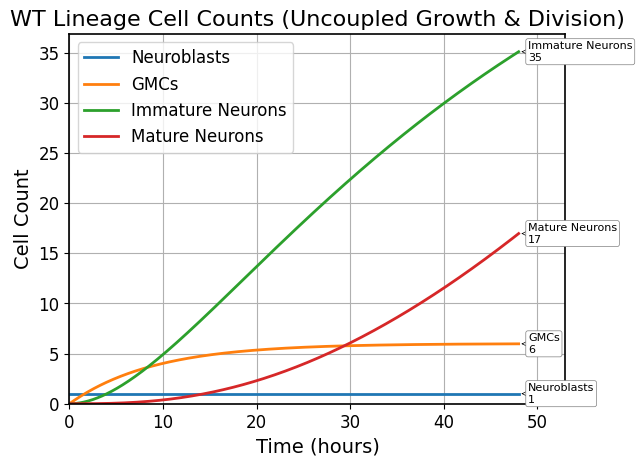

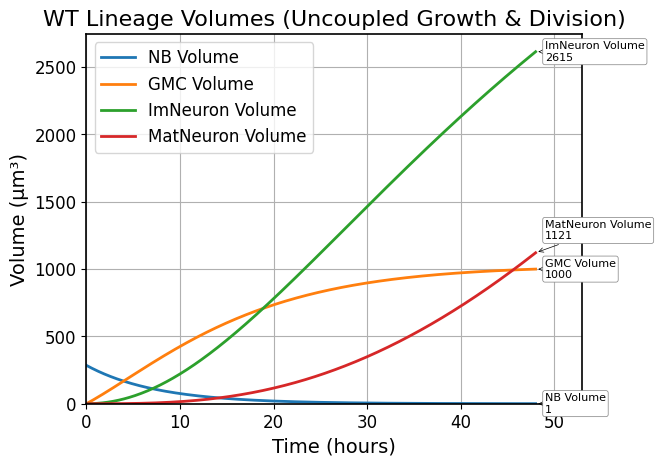

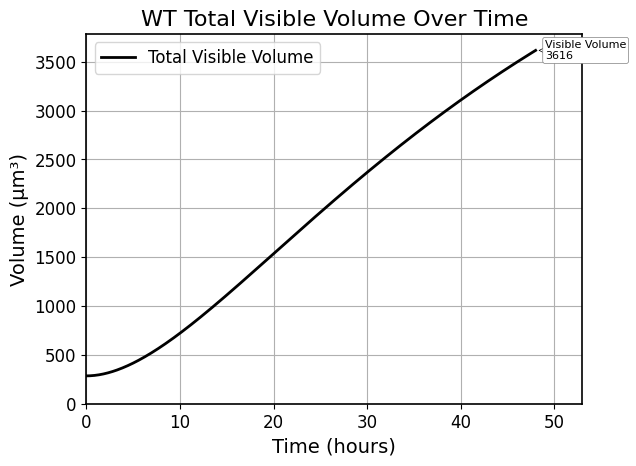

In [23]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_NB = 1 / 1.5                          # NB divides every 90 min
g_max_NB = (nb_vol * 0.2 / 0.25)        # NB grows 20% in 15 mins
k_GMC = 1 / 9                           # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9                # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48                       # Neurons mature in 48 hrs
sym_frac = 0.0                          # 0% symmetric divisions
K_feedback = .1                         # Volume at which NB growth rate is halved

params = [k_NB, g_max_NB, k_GMC, g_GMC, k_Neuron, sym_frac, K_feedback]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_uncoupled_lineagevol_feedback_on_growth,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

## Skipping mudmut simulation here as well. Same issue as previous growth regulations. So long as mudmut cells continue to increase in number, their growth rate will dominate

---
# Cell Count Feedback on NB Division Only

**Total lineage cell count negatively regulates NB division**  
In this model, neuroblast and GMC **growth** and **division** are uncoupled:

- **Neuroblast (NB) growth** occurs at a constant rate, independent of cell count.
- **NB division rate** is **negatively regulated** by the **total number of cells** in the lineage using a Michaelis-Menten-like function:
  $k_{\text{NB}} = k_{\text{NB,max}} \cdot \frac{K_{\text{feedback}}}{K_{\text{feedback}} + \text{TotalCellCount}}$
- **GMC growth and division** are both fixed and independent of feedback.
- **Immature neurons** mature into **mature neurons** at a constant rate.

This formulation allows us to isolate the effect of feedback on **division timing** while holding **growth dynamics constant**, disentangling their individual contributions to lineage expansion.

### Model Species
- **$N_{\text{NB}},\ V_{\text{NB}}$** — Neuroblasts (count and total volume)
- **$N_{\text{GMC}},\ V_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}},\ V_{\text{ImNeuron}}$** — Immature Neurons
- **$N_{\text{MatNeuron}},\ V_{\text{MatNeuron}}$** — Mature Neurons

### Model Parameters
- **$g_{\text{NB}},\ g_{\text{GMC}}$** — Growth rates for NB and GMC (volume/hour)
- **$k_{\text{NB,max}},\ k_{\text{GMC}}$** — Maximal NB and fixed GMC division rates (1/hour)
- **$k_{\text{Neuron}}$** — Immature neuron maturation rate (1/hour)
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions
- **$K_{\text{feedback}}$** — Cell count at which NB division rate is half-maximal

In [32]:
def neuroblast_model_uncoupled_cellcount_feedback_on_division(t, y, params):
    N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron = y
    g_NB, g_GMC, k_NB_max, k_GMC, k_Neuron, sym_frac, K_feedback = params

    Vavg_NB = V_NB / N_NB if N_NB > 0 else 0
    Vavg_GMC = V_GMC / N_GMC if N_GMC > 0 else 0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0

    total_cells = N_NB + N_GMC + N_ImNeuron + N_MatNeuron
    k_NB = k_NB_max * K_feedback / (K_feedback + total_cells)

    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    dN_NB = sym_divs
    dV_NB = g_NB * N_NB - k_NB * N_NB * Vavg_NB + sym_divs * Vavg_NB + asym_divs * 0.8 * Vavg_NB

    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = g_GMC * N_GMC + asym_divs * 0.2 * Vavg_NB - k_GMC * N_GMC * Vavg_GMC

    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = k_GMC * N_GMC * Vavg_GMC - k_Neuron * N_ImNeuron * Vavg_ImNeuron

    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

## WT Simulation
## Target Dynamics

Visible cell count excludes the neuroblast, so one cell should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 4058.22  | 3980.95  | 1170.29   |
| **Visible Cell Count**  | 53.45    | 47.50    | 26.24     |

### Parameter Justifications

Unspecified parameters are consistent with previous models in this notebook.

- **Maximum NB Division Rate** (`k_max_NB = 1 / .25`)
  - Matches previous models maximum division rate of 1/6 average division rate

- **Cell Count Feedback Strength** (`K_feedback = 10`)
  - Half-maximal inhibition of NB division occurs when the total lineage cell count reaches 10. Calibrated to approximate WT lineage size (~54 cells).

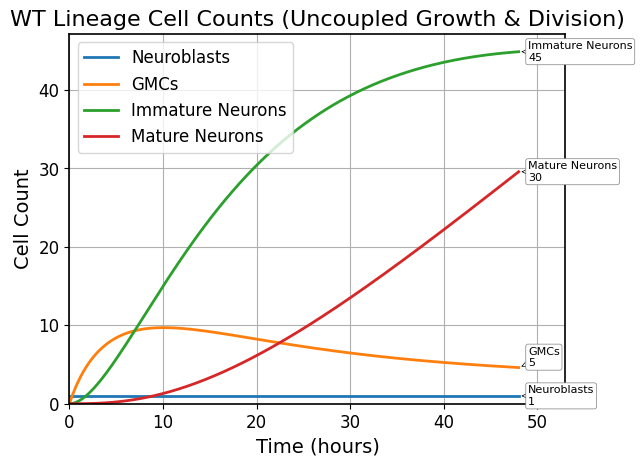

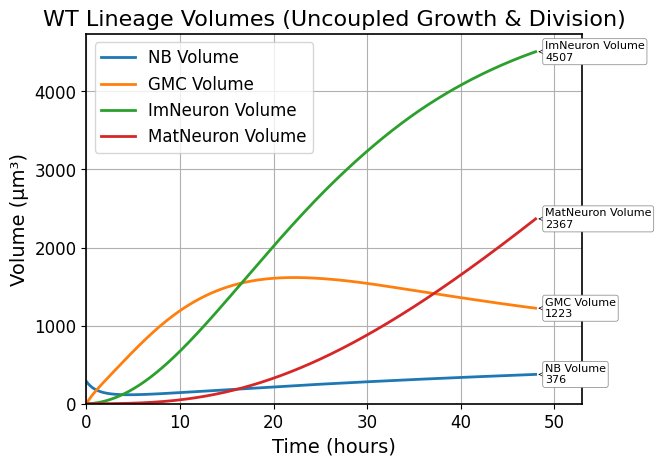

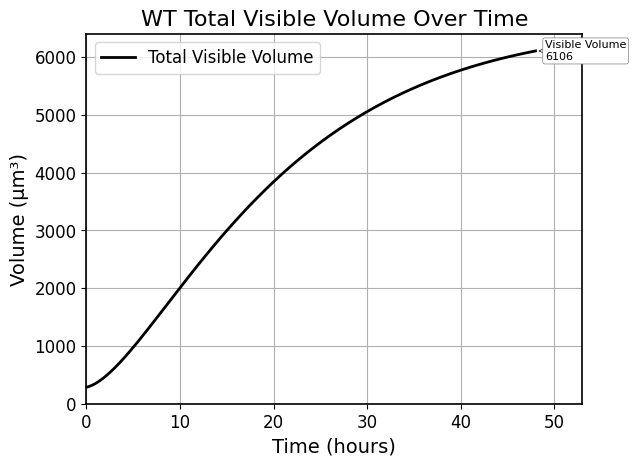

In [33]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_max_NB = 1 / .25                 # max NB divides every 15 min
g_NB = (nb_vol * 0.2 / 1.5)        # NB grows 20% in 15 mins
k_GMC = 1 / 9                      # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9           # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48                  # Neurons mature in 48 hrs
sym_frac = 0.0                     # 0% symmetric divisions
K_feedback = 10                    # Cell count at which NB division rate is halved

params = [g_NB, g_GMC, k_max_NB, k_GMC, k_Neuron, sym_frac, K_feedback]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_uncoupled_cellcount_feedback_on_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("WT Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

## mudmut Simulation
### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15

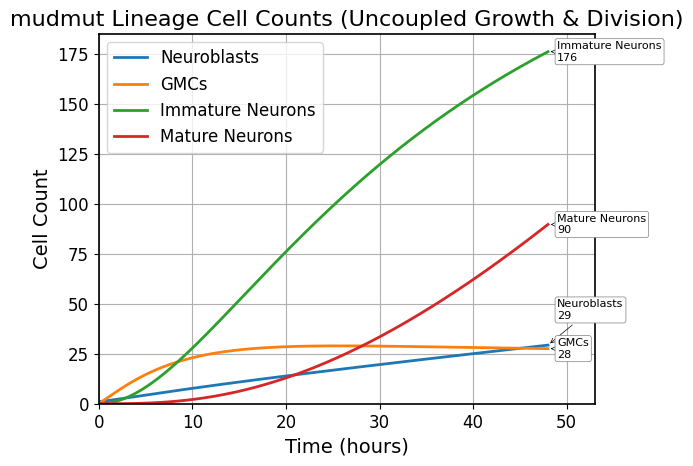

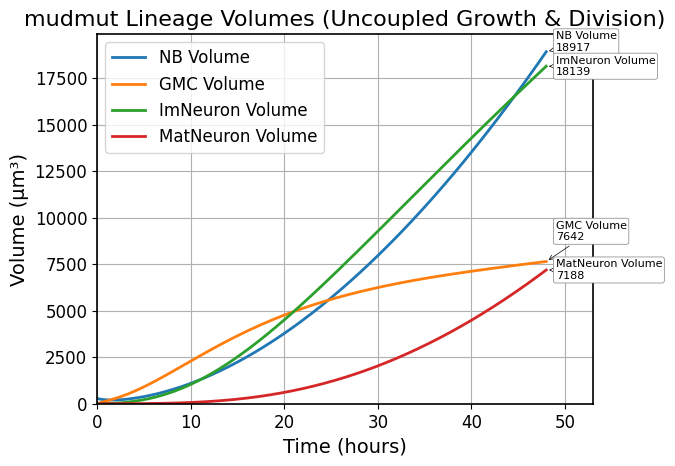

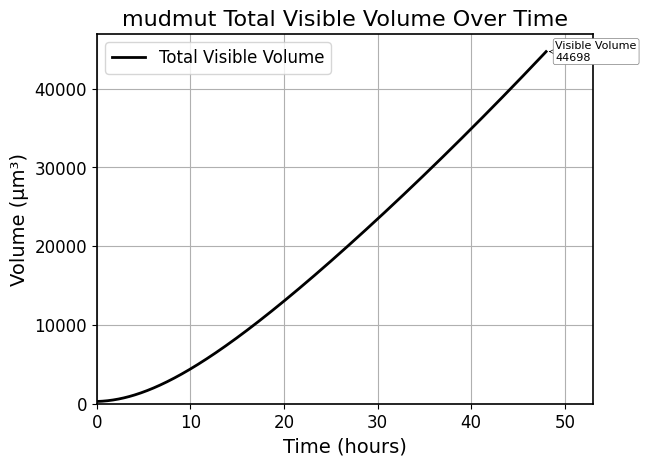

In [34]:
# Initial neuroblast volume
nb_vol = 285

# Parameters
k_max_NB = 1 / .25                 # max NB divides every 15 min
g_NB = (nb_vol * 0.2 / 1.5)        # NB grows 20% in 15 mins
k_GMC = 1 / 9                      # GMC divides every 9 hrs
g_GMC = nb_vol * 0.6 / 9           # GMC grows from 0.6x to 1.2x NB vol in 9 hrs
k_Neuron = 1 / 48                  # Neurons mature in 48 hrs
sym_frac = 0.15                    # 15% symmetric divisions
K_feedback = 10                    # Cell count at which NB division rate is halved

params = [g_NB, g_GMC, k_max_NB, k_GMC, k_Neuron, sym_frac, K_feedback]

# Initial conditions: [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

# Time span
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# Run simulation
sol = solve_ivp(
    neuroblast_model_uncoupled_cellcount_feedback_on_division,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# Plot cell counts
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
indices = [0, 2, 4, 6]
y_data = [sol.y[i] for i in indices]
for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut Lineage Cell Counts (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot volumes
fig, ax = plt.subplots()
labels_vol = ["NB Volume", "GMC Volume", "ImNeuron Volume", "MatNeuron Volume"]
indices_vol = [1, 3, 5, 7]
y_data_vol = [sol.y[i] for i in indices_vol]
for y, label in zip(y_data_vol, labels_vol):
    ax.plot(sol.t, y, label=label)
annotate_final_values(ax, sol.t, y_data_vol, labels_vol)
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Lineage Volumes (Uncoupled Growth & Division)")
ax.grid()
plt.legend()
plt.show()

# Plot: Total Visible Lineage Volume (excluding mature neurons)
fig, ax = plt.subplots()
total_visible_vol = sol.y[1] + sol.y[3] + sol.y[5]
ax.plot(sol.t, total_visible_vol, color="black", label="Total Visible Volume")
ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, [total_visible_vol], ["Visible Volume"])
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("mudmut Total Visible Volume Over Time")
ax.grid()
plt.legend()
plt.show()

---
# Applying lineage volume feedback to just NB division (not growth)

## WT Simulation
### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Neuroblast Division Rate** (`k_NB = 1 / 1.5`)
  - Neuroblasts divide every 90 minutes (from literature).

- **Neuroblast Growth Rate** (`nb_vol * 0.2 / 1.5`)
  - Neuroblasts grow by 20% of their starting volume over 1.5 hours (from literature).

- **GMC Division Rate** (`k_GMC = 1 / 9`)
  - GMCs divide every 9 hours (from literature).

- **GMC Growth Rate** (`nb_vol * 0.6 / 9`)
  - GMCs grow from 0.6× to 1.2× the NB volume in 9 hours (from literature).

- **Symmetric Division Fraction** ($\text{sym\_frac} = 0.0$)
  - All divisions are asymmetric (WT condition).

## mudmut Simulation
### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15

---
# Applying lineage volume feedback to just NB division (not growth)

## WT Simulation
### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

**Parameter Justifications**

Unspecified parameters are consistent with previous models in this notebook.

- **Neuroblast Division Rate** (`k_NB = 1 / 1.5`)
  - Neuroblasts divide every 90 minutes (from literature).

- **Neuroblast Growth Rate** (`nb_vol * 0.2 / 1.5`)
  - Neuroblasts grow by 20% of their starting volume over 1.5 hours (from literature).

- **GMC Division Rate** (`k_GMC = 1 / 9`)
  - GMCs divide every 9 hours (from literature).

- **GMC Growth Rate** (`nb_vol * 0.6 / 9`)
  - GMCs grow from 0.6× to 1.2× the NB volume in 9 hours (from literature).

- **Symmetric Division Fraction** ($\text{sym\_frac} = 0.0$)
  - All divisions are asymmetric (WT condition).

## mudmut Simulation
### Target Dynamics

We can summarize the expected lineage dynamics based on segmented microscopy data from the `control_nanobody_mud_DpnVolAll_Oct19_filtered.xlsx` dataset.

Visible cell count excludes the neuroblast, so 2-3 cells should be added to match simulated values.

| Metric                  | Mean     | Median   | Std Dev   |
|-------------------------|----------|----------|-----------|
| **Lineage Volume (µm³)**| 2576.88  | 2414.50  | 785.16    |
| **Visible Cell Count**  | 43.98    | 41.00    | 17.06     |

### Parameter Justification
- All parameters kept same as WT simulation except proportion of symmetric divisions increased from 0 to .15